In [18]:
import csv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

In [19]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [26]:
train_dataset = image_dataset_from_directory(
    "data/train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    "data/val",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    "data/test",
    image_size=(180, 180),
    batch_size=32)

Found 8819 files belonging to 15 classes.
Found 1891 files belonging to 15 classes.
Found 1890 files belonging to 15 classes.


## Balanceo de clases

In [ ]:
# Obtener las clases
classes = train_dataset.class_names

# Contar las imágenes por clase
count = {}
for c in classes:
    count[c] = len(os.listdir(f"data/train/{c}"))
    
# Graficar
plt.bar(count.keys(), count.values())
plt.xticks(rotation=45)
plt.show()

In [27]:
# Convertir a escala de grises
train_dataset_gray = train_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
validation_dataset_gray = validation_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))

In [28]:
# Verificar la forma de las imágenes
for images, labels in train_dataset_gray.take(1):
    print(f"Forma de las imágenes en escala de grises: {images.shape}")

Forma de las imágenes en escala de grises: (32, 180, 180, 1)


In [29]:
# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

2024-12-11 09:59:01.855661: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


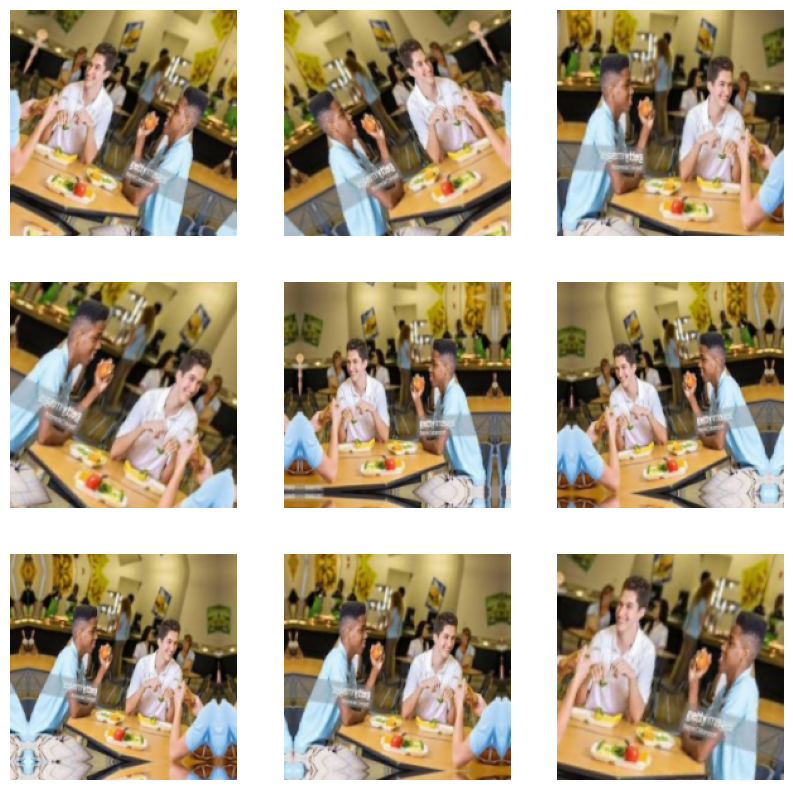

In [30]:
# Muestra imágenes con y sin aumento de datos
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [31]:
inputs = keras.Input(shape=(180, 180, 3))  
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# Bloque 1
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Dropout(0.2)(x)  # Dropout ligero (20%)

# Bloque 2
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Dropout(0.3)(x)  # Dropout moderado (30%)

# Bloque 3
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Dropout(0.3)(x)  # Dropout moderado (30%)

# Bloque 4
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Dropout(0.4)(x)  # Dropout más fuerte (40%)

# Bloque 5
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

# Capa totalmente conectada
x = layers.Dropout(0.5)(x)  # Dropout fuerte en la parte densa (50%)
x = layers.Dense(64, activation="relu")(x)

# Capa de salida
outputs = layers.Dense(15, activation="softmax")(x)

# Definir el modelo
model = keras.Model(inputs=inputs, outputs=outputs)


In [32]:
# Compilar el modelo
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [33]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,782,351 (6.80 MB)

 Trainable params: 1,782,351 (6.80 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Entrenar el modelo
history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset)


Epoch 1/100
275/276 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.0630 - loss: 2.7163

W0000 00:00:1733921961.682445   23415 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921961.685053   23415 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921961.687544   23415 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921961.693008   23415 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921961.696152   23415 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921961.699112   23415 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921961.702546   23415 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921961.705839   23415 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921961.708988   23415 gp

276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.0630 - loss: 2.7163

W0000 00:00:1733921962.909094   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921962.912993   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921962.924369   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921962.937348   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921962.950041   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921962.962082   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921962.972011   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921962.988325   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733921963.001870   23414 gp

276/276 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.0631 - loss: 2.7162 - val_accuracy: 0.0746 - val_loss: 2.6949
Epoch 2/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.0902 - loss: 2.6745 - val_accuracy: 0.1121 - val_loss: 2.6240
Epoch 3/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.1188 - loss: 2.6022 - val_accuracy: 0.1539 - val_loss: 2.5535
Epoch 4/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.1433 - loss: 2.5544 - val_accuracy: 0.1692 - val_loss: 2.4586
Epoch 5/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.1724 - loss: 2.4832 - val_accuracy: 0.1613 - val_loss: 2.5446
Epoch 6/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.1991 - loss: 2.4376 - val_accuracy: 0.2337 - val_loss: 2.3749
Epoch 7/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.2278 - loss: 2.3406 - val_accuracy: 0.2649 - val_loss: 2.1984
Epoch 8/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.2443 - loss: 2.2864 - val_

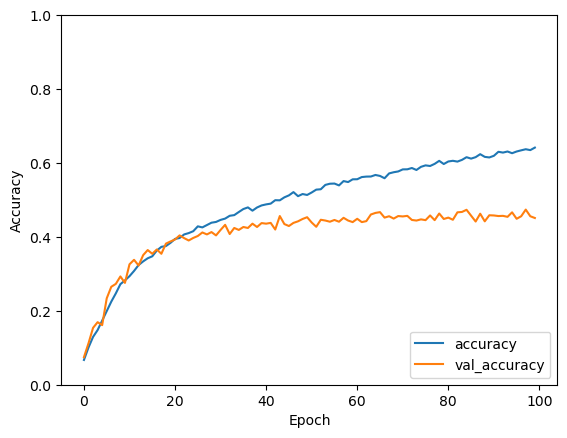

In [35]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [36]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4650 - loss: 2.0047

W0000 00:00:1733924000.300672   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.312353   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.313822   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.315157   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.316490   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.317789   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.319682   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.321011   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.322340   23414 gp

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4653 - loss: 2.0057
Test loss: 2.0207979679107666
Test accuracy: 0.46878308057785034


W0000 00:00:1733924000.505993   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.507405   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.508984   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.510560   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.512106   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.515315   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.519175   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.520680   23414 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733924000.522415   23414 gp

In [45]:
# Guardar el modelo
model.save("/home/luciano/Documentos/Facultad/4to/2_semestre/Inteligencia_Artificial_2/ia2-uncuyo-2024/human-action-recognition/humanActionRecognition/models/model01.keras")